In [42]:
from io import open
import glob
import os
import random
import unicodedata
import string

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [43]:
FILE_PATH = 'datasets/names/*.txt'

Turn a Unicode string to plain ASCII (may alter the meaning of words)



https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-in-a-python-unicode-string/518232#518232

In [44]:
EOS = '/'

all_letters = string.ascii_letters + " .'" + EOS
n_letters = len(all_letters)

all_letters, n_letters


("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .'/", 56)

In [45]:
EOS_INDEX = n_letters - 1

In [46]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [47]:
print(unicode_to_ascii("O'Néàl"))

O'Neal


In [48]:
def find_files(path): 
    return glob.glob(path)

In [49]:
total_names = 0

language_names = {}

all_languages = []

for filename in find_files(FILE_PATH):
    
    language = os.path.splitext(os.path.basename(filename))[0]
    
    all_languages.append(language)
    
    names_in_file = open(filename, encoding='utf-8').read().strip().split('\n')
    
    names = [unicode_to_ascii(name) for name in names_in_file]
    
    language_names[language] = names
    
    total_names += len(names)

all_languages

['Czech',
 'German',
 'Arabic',
 'Japanese',
 'Chinese',
 'Vietnamese',
 'Russian',
 'French',
 'Irish',
 'English',
 'Spanish',
 'Greek',
 'Italian',
 'Portuguese',
 'Scottish',
 'Dutch',
 'Korean',
 'Polish']

In [50]:
n_languages = len(all_languages)
n_languages, total_names

(18, 20074)

In [51]:
def letter_to_tensor(letter):
    
    tensor = torch.zeros(1, n_letters)
    tensor[0][all_letters.find(letter)] = 1
    
    return tensor

In [52]:
print(letter_to_tensor('a'))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


In [53]:
def input_name_to_tensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    
    for li, letter in enumerate(name):
        tensor[li][0][all_letters.find(letter)] = 1
    
    return tensor

In [54]:
anish_input_tensor = input_name_to_tensor('Anish')

anish_input_tensor.size()

torch.Size([5, 1, 56])

In [55]:
anish_input_tensor

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

In [56]:
def target_name_to_tensor(name):
    letter_indexes = [all_letters.find(name[li]) for li in range(1, len(name))]
    
    letter_indexes.append(EOS_INDEX)
    
    return torch.LongTensor(letter_indexes)

In [57]:
target_name_to_tensor('Anish')

tensor([13,  8, 18,  7, 55])

In [58]:
def language_to_tensor(language):
    li = all_languages.index(language)
    
    category_tensor = torch.zeros(1, n_languages)

    category_tensor[0][li] = 1
    
    return category_tensor

In [59]:
language_to_tensor('English')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [60]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_languages + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_languages + input_size + hidden_size, output_size)

        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        
        self.dropout = nn.Dropout(0.2)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, language, input_t, hidden):

        input_combined = torch.cat((language, input_t, hidden), 1)

        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        
        output_combined = torch.cat((hidden, output), 1)
        
        output = self.o2o(output_combined)
        output = self.dropout(output)

        output = self.log_softmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [61]:
n_hidden = 256

rnn = RNN(n_letters, n_hidden, n_letters)

In [62]:
language = language_to_tensor('English')

input_t = letter_to_tensor('S')

hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(language, input_t, hidden)

print('output size =', output.size())
print('next_hidden size =', next_hidden.size())

output size = torch.Size([1, 56])
next_hidden size = torch.Size([1, 256])


In [63]:
def letter_from_output(output):
    
    _, top_i = output.topk(1)
    
    letter_i = top_i[0].item()
    
    return all_letters[letter_i], letter_i

In [64]:
letter_from_output(output)

('a', 0)

In [65]:
def random_training_example():
    
    random_language_index = random.randint(0, n_languages - 1)
    language = all_languages[random_language_index]
    
    random_language_names = language_names[language]
    name = random_language_names[random.randint(0, len(random_language_names) - 1)]
    
    language_tensor = language_to_tensor(language)
    
    input_name_tensor = input_name_to_tensor(name)
    target_name_tensor = target_name_to_tensor(name)
    
    return language_tensor, input_name_tensor, target_name_tensor

In [66]:
random_training_example()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0

In [67]:
random_training_example()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0

In [68]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

In [69]:
def train(language_tensor, input_name_tensor, target_name_tensor):
    
    target_name_tensor.unsqueeze_(-1)
    
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_name_tensor.size(0)):
        
        output, hidden = rnn(language_tensor, input_name_tensor[i], hidden)
            
        l = criterion(output, target_name_tensor[i])
        
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_name_tensor.size(0)

In [70]:
n_iters = 1000000
current_loss = 0
all_losses = []

In [71]:
for iteration in range(1, n_iters + 1):
    
    language_tensor, input_name_tensor, target_name_tensor = random_training_example()
    
    output, loss = train(language_tensor, input_name_tensor, target_name_tensor)
    current_loss += loss
    
    if iteration % 5000 == 0:
        print('(%d %d%%) %.4f' % (iteration, iteration / n_iters * 100, loss))

    if iteration % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

(5000 0%) 2.9934
(10000 1%) 2.9895
(15000 1%) 2.3269
(20000 2%) 2.8472
(25000 2%) 2.7318
(30000 3%) 1.8880
(35000 3%) 2.5476
(40000 4%) 2.5706
(45000 4%) 3.1612
(50000 5%) 1.0460
(55000 5%) 2.2553
(60000 6%) 2.3635
(65000 6%) 1.9634
(70000 7%) 3.4911
(75000 7%) 2.1275
(80000 8%) 2.7143
(85000 8%) 1.4689
(90000 9%) 2.4598
(95000 9%) 2.5199
(100000 10%) 2.2962
(105000 10%) 2.4771
(110000 11%) 1.9802
(115000 11%) 2.7312
(120000 12%) 2.4414
(125000 12%) 2.2337
(130000 13%) 1.4351
(135000 13%) 2.8333
(140000 14%) 3.5804
(145000 14%) 1.9929
(150000 15%) 1.7873
(155000 15%) 2.1497
(160000 16%) 1.9527
(165000 16%) 2.8382
(170000 17%) 2.1948
(175000 17%) 2.1511
(180000 18%) 2.3227
(185000 18%) 2.9213
(190000 19%) 2.5309
(195000 19%) 2.0027
(200000 20%) 2.3311
(205000 20%) 2.6268
(210000 21%) 2.6107
(215000 21%) 2.2593
(220000 22%) 1.9410
(225000 22%) 2.1212
(230000 23%) 2.2177
(235000 23%) 2.5188
(240000 24%) 3.8040
(245000 24%) 2.8728
(250000 25%) 1.9372
(255000 25%) 2.1470
(260000 26%) 2.8321

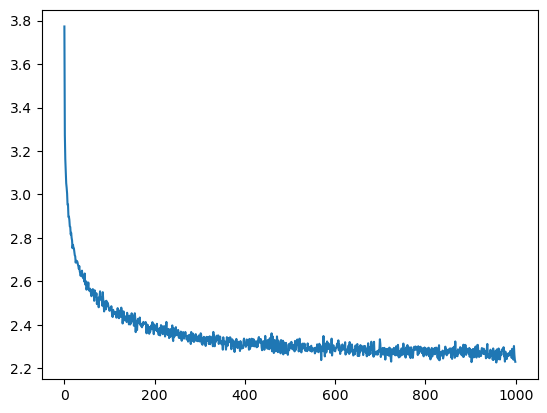

In [72]:
plt.figure()
plt.plot(all_losses)

In [75]:
MAX_LENGTH = 12

def sample(language, start_letter='A'):
    
    rnn.eval()

    with torch.no_grad():  
        language_tensor = language_to_tensor(language)
        
        input_t = input_name_to_tensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(MAX_LENGTH):
            
            output, hidden = rnn(language_tensor, input_t[0], hidden)
            
            letter = letter_from_output(output)[0]

            if letter == EOS:
                break
            else:
                output_name += letter

            input_t = input_name_to_tensor(letter)

        return output_name

In [76]:
for language in all_languages:
    for letter in all_letters[26:-4]:
        print("Here is a made up " + str(language) + " word starting with the letter " + str(letter) + ": " + str(sample(language, letter)))

Here is a made up Czech word starting with the letter A: Alden
Here is a made up Czech word starting with the letter B: Berten
Here is a made up Czech word starting with the letter C: Cartel
Here is a made up Czech word starting with the letter D: Dellack
Here is a made up Czech word starting with the letter E: Estevek
Here is a made up Czech word starting with the letter F: Ferrek
Here is a made up Czech word starting with the letter G: Granck
Here is a made up Czech word starting with the letter H: Handel
Here is a made up Czech word starting with the letter I: Inak
Here is a made up Czech word starting with the letter J: Janda
Here is a made up Czech word starting with the letter K: Koura
Here is a made up Czech word starting with the letter L: Lecker
Here is a made up Czech word starting with the letter M: Matsen
Here is a made up Czech word starting with the letter N: Navek
Here is a made up Czech word starting with the letter O: Olever
Here is a made up Czech word starting with t